# **Introduction to GAN**

1) Import dependencies

In [10]:
!pip install tensorflow-gpu==2.1.0

In [11]:
!pip install tensorflow-datasets

In [12]:
!pip install imageio

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from IPython import display
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import random

2) Load the Fashion MNIST dataset

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [14]:
# Reshape dataset
train_images = train_images.reshape(train_images.shape[0], 
                                    train_images.shape[1],
                                    train_images.shape[2],
                                    1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

In [0]:
# Normalize data with ranges between (-1 , 1)
train_images = (train_images - 127.5) / 127.5

In [0]:
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256


# Create a dataset using from_tensor_slices Data API
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

3) Visualize the dataset

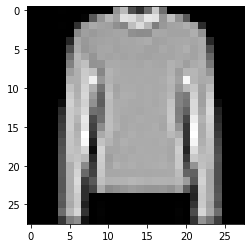

In [17]:
num = random.randint(1, len(train_images))
plt.imshow(train_images[num].reshape((28,28)) , cmap = 'gray')

4) Generator network

In [0]:
generator = keras.models.Sequential([
            keras.layers.Dense(7 * 7 * 256, 
                               input_shape = [100]),
            keras.layers.Reshape([7, 7, 256]),
            keras.layers.BatchNormalization(),

            keras.layers.Conv2DTranspose(128, kernel_size = 5, 
                                         strides = 1, 
                                         padding = 'same', 
                                         use_bias = False, 
                                         activation = 'selu'),
            keras.layers.BatchNormalization(),

            keras.layers.Conv2DTranspose(64, kernel_size = 5, 
                                         strides = 2, 
                                         padding = 'same', 
                                         use_bias = False, 
                                         activation = 'selu'),
            keras.layers.BatchNormalization(),

            keras.layers.Conv2DTranspose(1, kernel_size = 5, 
                                         strides = 2, 
                                         padding = 'same', 
                                         use_bias = False, 
                                         activation = 'tanh'),            
])

In [19]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)
generated_image.shape

TensorShape([1, 28, 28, 1])

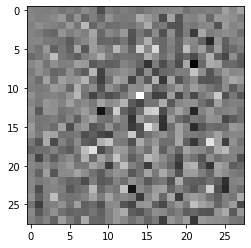

In [20]:
generated_image = tf.reshape(generated_image, [28, 28])
plt.imshow(generated_image, cmap='gray')

5) Discriminator network

In [0]:
discriminator = keras.models.Sequential([
                keras.layers.Conv2D(64, kernel_size = 5, 
                                    strides = 2, 
                                    padding = 'same', 
                                    use_bias = False, 
                                    activation = 'selu'),
                keras.layers.Dropout(0.4),

                keras.layers.Conv2D(128, kernel_size = 5, 
                                    strides = 2, 
                                    padding = 'same', 
                                    use_bias = False, 
                                    activation = 'selu'),
                keras.layers.Dropout(0.4),

                keras.layers.Flatten(),
                keras.layers.Dense(1, activation = 'sigmoid'),                     
])

In [22]:
gan = keras.models.Sequential([generator, discriminator])
generator.summary()
discriminator.summary()
gan.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        2

6) Model compilation and loss definition

In [0]:
# Define crossentropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [0]:
# Discriminator loss function
# Real images are 1 and fake are 0
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
# Generator loss function
# Fake images will be clasified as 1
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Nadam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Nadam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

7) Model training

In [0]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 16

# Create a seed of random values
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):

  # Generate random noise
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  
  # Gradient tracking
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    # Step 1: Feed the noise to the generator
    generated_images = generator(noise, training = True)

    # Step 2: pass fake and real images to the discriminator to classify
    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    # Step 3: calculate the resulting loss
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Step 4: calculate the gradients
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Step 5: apply to optimizer and update the weights
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):

  # Training loop
  for epoch in range(epochs):

    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Display images
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save results every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  # Display images
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

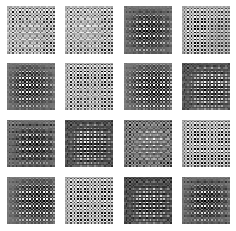

Time for epoch 79 is 6.196048736572266 sec


In [0]:
train(train_dataset, epochs)